In [1]:
import datetime
import pandas as pd
import numpy as np
from collections import defaultdict
from typing import Dict, List, Optional, Tuple, Union

from pylab import cm
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

from bigbang.analysis.listserv import ListservMailList
#from bigbang.bigbang_io import pandas_dataframe_to_mbox

from tgpp.config.config import CONFIG
import tgpp.ingress.queries as Queries

plt.style.use("./publication_jcap.mplstyle")

In [5]:
def format_dictionary(dic: dict, threshold: Union[int, float]) -> dict:
    """
    Format dictionary for pie plot.
    """
    dic_sorted = {
        list(dic.keys())[indx]: list(dic.values())[indx]
        for indx in np.argsort(list(dic.values()))[::-1]
    }

    percentages = ListservMailList.to_percentage(list(dic_sorted.values()))
    dic_sorted = {key: value for key, value in zip(dic_sorted.keys(), percentages)}

    dic_filtered = {"others": 0}
    
    if isinstance(threshold, int):
        for index, (key, value) in enumerate(dic_sorted.items()):
            if index <= threshold:
                dic_filtered[key] = value
            else:
                dic_filtered["others"] += value
    elif isinstance(threshold, float):
        for key, value in dic_sorted.items():
            if value >= threshold:
                dic_filtered[key] = value
            else:
                dic_filtered["others"] += value
    return dic_filtered

## Load data

In [23]:
file_path = "/Users/christovis/Documents/InternetGovernance/bigbang/examples/organizations/organization_categories.csv"
df_organization_categories = pd.read_csv(
    file_path,
    sep=",",
    header=0,
    index_col=False,
)
# choose columns of interest
df_nation = df_organization_categories[[
    "name",
    "nationality",
    "email domain names",
]]
# filter out all non-empty cells
df_nation = df_nation.dropna()

indices = [
    idx
    for idx, row in df_nation.iterrows()
    if len(row['email domain names'].split(',')) > 1
]    

df_nation_multi = df_nation.loc[indices]
df_nation_single = df_nation.drop(indices)

_df_nation_multi = defaultdict(list)
for idx, row in df_nation_multi.iterrows():
    _row = row
    email_domains = row['email domain names'].split(',')
    for email_domain in email_domains:
        _row['email domain names'] = email_domain.strip()
        for key, value in _row.to_dict().items():
            _df_nation_multi[key].append(value)
df_nation = pd.concat([df_nation_single, pd.DataFrame.from_dict(_df_nation_multi)], ignore_index=True)

In [24]:
mlist_name = "3GPP_TSG_SA_WG3_LI"

# load target-set (Tset)
df = pd.read_hdf(
    CONFIG.folder_target_set + f"{mlist_name}.h5",
    key="df",
    header=0,
    index_col=0,
)
df = df.dropna()
df['msg-date'] =  pd.to_datetime(df['msg-date'], format="%a, %d %b %Y %H:%M:%S %z")

In [25]:
df['msg-nationality'] = np.nan
for idx, row in df.iterrows():
    _, _, domain = ListservMailList.get_name_localpart_domain(row['msg-from'])
    nationality = df_nation[df_nation['email domain names'] == domain]['nationality'].values
    if len(nationality) > 0:
        # TODO: there are some domain names associated to multiple nationailies
        df.loc[idx, 'msg-nationality'] = nationality[0]
df = df.dropna()
df = Queries.remove_text_wo_query(df)
df = Queries.remove_query_wo_text(df)

In [26]:
# get Tset Email header fields
non_query_columns = [col for col in df.columns if col.startswith('msg-')]
df_msg = df.loc[:, df.columns.isin(non_query_columns)]

# get Tset Email keyterms
df_qu = df.loc[:, ~df.columns.isin(non_query_columns)]
body_query_columns = [col for col in df_qu.columns if col.startswith('body-')]
attachment_query_columns = [col for col in df_qu.columns if col.startswith('attachment-')]
df_qu_bo = df.loc[:, body_query_columns]
df_qu_at = df.loc[:, attachment_query_columns]

df_qu_bo = Queries.remove_text_wo_query(df_qu_bo)
df_qu_bo = Queries.remove_query_wo_text(df_qu_bo)

df_qu_at = Queries.remove_text_wo_query(df_qu_at)
df_qu_at = Queries.remove_query_wo_text(df_qu_at)

# load search-set (Sset)
mlist = ListservMailList.from_mbox(
    name=mlist_name,
    filepath=CONFIG.folder_search_set + f"{mlist_name}.mbox",
)

## Nationality of Tset Email

In [27]:
key, count = np.unique(df_msg['msg-nationality'].values, return_counts=True)
idx = np.argsort(count)
key = key[idx]
count = count[idx]

for k, c in zip(key, count):
    print(k, c)

Canada 1
Denmark 1
Italy 3
Japan 3
Austria 6
Norway 11
China 20
Netherlands 28
Spain 49
the Netherlands 98
Australia 103
Sweden 272
Germany 371
France 687
United Kingdom 1068
United States 2008


In [28]:
notattachment_query_columns = [col for col in df.columns if not col.startswith('attachment-')]
_df = Queries.remove_text_wo_query(df[notattachment_query_columns])
_df = Queries.remove_query_wo_text(_df)
key, count = np.unique(_df['msg-nationality'].values, return_counts=True)
idx = np.argsort(count)
key = key[idx]
count = count[idx]

for k, c in zip(key, count):
    print(k, c

SyntaxError: '(' was never closed (976139467.py, line 10)

In [ ]:
notbody_query_columns = [col for col in df.columns if not col.startswith('body-')]
_df = Queries.remove_text_wo_query(df[notbody_query_columns])
_df = Queries.remove_query_wo_text(_df)
key, count = np.unique(_df['msg-nationality'].values, return_counts=True)
idx = np.argsort(count)
key = key[idx]
count = count[idx]

for k, c in zip(key, count):
    print(k, c)

## Count Emails and Attachements containing keyterms

In [29]:
df_qu_bo[df_qu_bo != 0] = 1
queries_count_body = df_qu_bo.sum(axis=0).sort_values()

df_qu_at[df_qu_at != 0] = 1
queries_count_attachment = df_qu_at.sum(axis=0).sort_values()

In [30]:
queries_count_body#[-50::]

body- uus                                         1
body- mec                                         1
body- law intercept identifi                      1
body- nds                                         1
body- ip multimedia core network subsystem        1
                                               ... 
body- cc                                       1165
body- iri                                      1430
body- http                                     1612
body- law intercept                            1836
body- li                                       4182
Length: 247, dtype: int64

In [31]:
queries_count_attachment

attachment- home subscrib server            1
attachment- remot oper servic element       1
attachment- rai                             1
attachment- mime                            1
attachment- quic                            1
                                         ... 
attachment- mdf                           129
attachment- ue                            133
attachment- iri                           153
attachment- cc                            161
attachment- li                            269
Length: 269, dtype: int64

## Find Email first to mention keyterms

In [32]:
def find_first_keyterm_mention(df: pd.DataFrame, keyterm: str):
    """
    Parameters:
    -----------
    keyterm: is the same as the column name in the DataFrame.
    
    Returns
    -------
    Returns index of Email tha first mentiones keyterm.
    """
    _df = df[df[keyterm] != 0]
    min_datetime = _df['msg-date'].values.min()
    index = df[df['msg-date'] == min_datetime].index[0]
    return index

body_query_columns = [col for col in df_qu.columns if col.startswith('body-')]
indices = [
    find_first_keyterm_mention(df, column)
    for column in body_query_columns
]
df_bo_first = df.loc[indices]

attachment_query_columns = [col for col in df_qu.columns if col.startswith('attachment-')]
indices = [
    find_first_keyterm_mention(df, column)
    for column in attachment_query_columns
]
df_at_first = df.loc[indices]

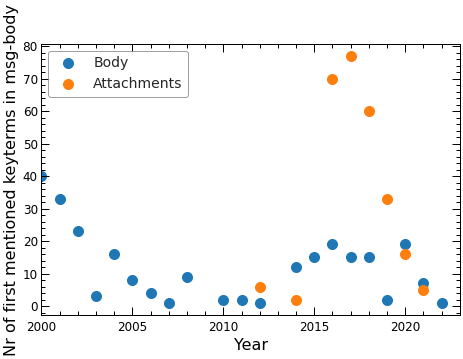

In [33]:
years, couts = np.unique([dt.year for dt in df_bo_first['msg-date']], return_counts=True)
plt.scatter(years, couts, label="Body")

years, couts = np.unique([dt.year for dt in df_at_first['msg-date']], return_counts=True)
plt.scatter(years, couts, label="Attachments")

plt.xlim(2000, 2023)
plt.xlabel('Year')
plt.ylabel('Nr of first mentioned keyterms in msg-body')
plt.legend()

#"""
plt.savefig(
    f"{mlist_name}_time_kw_first_mentioned.png",
    format='png',
    transparent=True,
    dpi=300,
    bbox_inches='tight',
)#"""

## Domains and Nationality of first mentioned keyterms

In [34]:
mlist_bo_first = ListservMailList.from_pandas_dataframe(
    df=mlist.df[mlist.df['message-id'].isin(df_bo_first['msg-message-id'].values)],
    name=mlist_name,
)
mlist_at_first = ListservMailList.from_pandas_dataframe(
    df=mlist.df[mlist.df['message-id'].isin(df_at_first['msg-message-id'].values)],
    name=mlist_name,
)

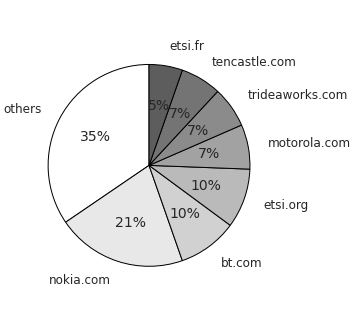

In [35]:
dicts = mlist_bo_first.get_messagescount(
    header_fields=['from', 'comments-to'],
    per_address_field='domain',
    per_year=False,
)
threshold = 6
dict_filtered = format_dictionary(dicts["from"], threshold)

# plot figure
fig, axis = plt.subplots(
    1, 1,
    figsize=(4, 6),
)
nr_colors = len(dict_filtered.values()) + 3
cmap = cm.binary(np.arange(nr_colors) / nr_colors)

axis.pie(
    dict_filtered.values(),
    radius=3.,
    wedgeprops={"edgecolor":"k",'linewidth': 1, 'linestyle': '-'},
    labels=dict_filtered.keys(),
    labeldistance=1.2,
    autopct='%1.f%%',
    shadow=False,
    startangle=90,
    colors=cmap,
)
axis.axis('equal')

#"""
plt.savefig(
    f"{mlist_name}_stakeholder_kw_first_mentioned.png",
    format='png',
    transparent=True,
    dpi=300,
    bbox_inches='tight',
)#"""

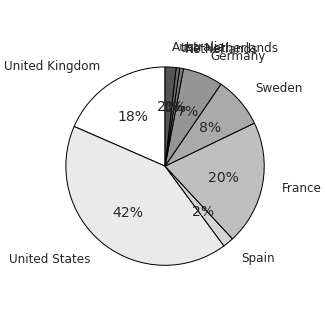

In [36]:
dict_filtered = defaultdict(int)
for key, value in dicts["from"].items():
    if key in df_nation["email domain names"].values:
        nationality = df_nation[df_nation["email domain names"] == key]['nationality'].values[0]
        dict_filtered[nationality] += value

# plot figure
fig, axis = plt.subplots(
    1, 1,
    figsize=(4, 6),
)
nr_colors = len(dict_filtered.values()) + 3
cmap = cm.binary(np.arange(nr_colors) / nr_colors)

axis.pie(
    dict_filtered.values(),
    radius=3.,
    wedgeprops={"edgecolor":"k",'linewidth': 1, 'linestyle': '-'},
    labels=dict_filtered.keys(),
    labeldistance=1.2,
    autopct='%1.f%%',
    shadow=False,
    startangle=90,
    colors=cmap,
)
axis.axis('equal')

#"""
plt.savefig(
    f"{mlist_name}_nationality_kw_first_mentioned.png",
    format='png',
    transparent=True,
    dpi=300,
    bbox_inches='tight',
)#"""

## Domains mentioning keyterms

In [49]:
nonattachment_query_columns = [col for col in df_qu.columns if not col.startswith('attachment-')]
df_bo = df.loc[:, nonattachment_query_columns]
df_bo = Queries.remove_text_wo_query(df_bo)
df_bo = Queries.remove_query_wo_text(df_bo)
mlist_bo = ListservMailList.from_pandas_dataframe(
    df=mlist.df[mlist.df['message-id'].isin(df_bo['msg-message-id'].values)],
    name=mlist_name,
)

In [5]:
cooccurrence = _df_kw.T.dot(_df_kw).values
np.fill_diagonal(cooccurrence, 0)
#cooccurrence = cooccurrence / np.max(cooccurrence)
df_cooccurrence = pd.DataFrame(
    cooccurrence,
    index=keywords,
    columns=keywords,
)
# re-scale
df_cooccurrence = df_cooccurrence.apply(lambda x: x**(1/2))
# mask upper-right triangle
df_cooccurrence = df_cooccurrence.where(
    np.tril(np.ones(df_cooccurrence.shape)).astype(np.bool)
)

NameError: name '_df_kw' is not defined

In [ ]:
fig, ax = plt.subplots(
    1, 1,
    sharex=False, sharey=False,
    figsize=(16, 16),
    facecolor="w",
    edgecolor="k",
)
fig.subplots_adjust(
    hspace=0.0,
    wspace=0.0,
)

hmap = sns.heatmap(
    df_cooccurrence,
    cmap="Spectral",
    square=True,
    linewidths=0.5,
    cbar_kws={
        'label': r'$\sqrt{\epsilon}$, with $\epsilon =$ co-occurrence count',
        'shrink': 0.8,
    },
)

ax.set_yticklabels(ax.get_yticklabels(), rotation=0)